 # Implementation of Deep Learning Model Using Tensorflow, I implemented this project by considering following steps:

- Initialize variables
- Start your own session
- Train algorithms 
- Implement a Neural Network

Programing frameworks can not only shorten your coding time, but sometimes also perform optimizations that speed up your code.

- Training set: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- Test set: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).

Note that this is a subset of the SIGNS dataset. The complete dataset contains many more signs.

Here are examples for each number, and how an explanation of how we represent the labels. These are the original pictures, before we lowered the image resolutoion to 64 by 64 pixels.

<img src="./example.png" style="width:800px;height:350px;"><caption><center> <u><font color='purple'> **Figure 1**</u><font color='purple'>: SIGNS dataset <br> <font color='black'> </center>


**Note** that 12288 comes from  64×64×364×64×3 . Each image is square, 64 by 64 pixels, and 3 is for the RGB colors. Please make sure all these shapes make sense to you before continuing.

**The model** is *LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX*. The SIGMOID output layer has been converted to a SOFTMAX. A SOFTMAX layer generalizes SIGMOID to when there are more than two classes. 

**To improve accuracy** I have used L2 regulariztion and Dropout techniques to reduce overfiting.



## 1 - Exploring the Tensorflow Library

To start, you will import the library:


In [33]:
import h5py #loading data from HD5
import numpy as np #scientific computing with python
import scipy #for image processing 
from PIL import Image
from scipy import ndimage
import tensorflow as tf #machine learning library (open source)
import math
import matplotlib.pyplot as plt #ploting graph
from tensorflow.python.framework import ops

%matplotlib inline

## 2 - Defining all the necessary methods for the project


- load_datasets() : is for loading the image data sets from HD5(The h5py package is a Pythonic interface to the HDF5 binary data format).   

In [34]:
def load_datasets():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])# train set labels
    
    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

    classes = np.array(test_dataset["list_classes"][:]) #different types of classes for classification
    
    train_set_y_orig = train_set_y_orig.reshape(1,train_set_y_orig.shape[0])
    test_set_y_orig = test_set_y_orig.reshape(1,test_set_y_orig.shape[0])
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes
    

- random_mini_batches(): Creates a list of random minibatches from (X, Y) 

 Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)

In [36]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    
    
     # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) 
    # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


- convert_to_one_hot(): 
Many times in deep learning you will have a y vector with numbers ranging from 0 to C-1, where C is the number of classes. If C is for example 4, then you might have the following y vector which you will need to convert as follows:

<img src="./onehot.png" style="width:600px;height:150px;">



This is called a "one hot" encoding, because in the converted representation exactly one element of each column is "hot" (meaning set to 1). To do this conversion in numpy, you might have to write a few lines of code.

In [37]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

- create_placeholders(): This will allow us to pass our training data in when we run our session.

**Expected Output**: 

<table> 
    <tr> 
        <td>
            **X**
        </td>
        <td>
        Tensor("Placeholder_1:0", shape=(12288, ?), dtype=float32) (not necessarily Placeholder_1)
        </td>
    </tr>
    <tr> 
        <td>
            **Y**
        </td>
        <td>
        Tensor("Placeholder_2:0", shape=(10, ?), dtype=float32) (not necessarily Placeholder_2)
        </td>
    </tr>

</table>

In [38]:
def create_placeholders(n_x,n_y):
    X = tf.placeholder(tf.float32,shape=[n_x,None],name='X')
    Y = tf.placeholder(tf.float32, shape=[n_y,None], name='Y')
    
    return X, Y

- initialize_parameters(): 
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    
    

In [39]:
def initialize_parameters():
    W1 = tf.get_variable("W1", [25, 12288], initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable("b1", [25, 1], initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable("b2", [12, 1], initializer=tf.contrib.layers.xavier_initializer())
    W3 = tf.get_variable("W3", [6, 12], initializer=tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable("b3", [6, 1], initializer=tf.contrib.layers.xavier_initializer())
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

- forward_propagation() : here we will now implement the forward propagation module in tensorflow. The function will take in a dictionary of parameters and it will complete the forward pass. The functions you will be using are:

tf.add(...,...) to do an addition

tf.matmul(...,...) to do a matrix multiplication

tf.nn.relu(...) to apply the ReLU activation

Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX

# Adding dropout in first hidden layer
Dropout: It is widely used regularized technique that is specific to deep learning. It randomly shutsdown some neurons in each iteration. When you shutdown some neurons you actually modify your model. With dropout your neurons become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time.



    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit

In [52]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)
    A1 = tf.nn.relu(Z1)
    A1 = tf.nn.dropout(A1, keep_prob = 0.99) #adding drop out for first layer with 0.98 probability.
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    A2 = tf.nn.relu(Z2)
    #A2 = tf.nn.dropout(A2, keep_prob = 0.91)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    
    return Z3
    

- compute_cost():  it is very easy to compute the cost using:

tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ..., labels = ...))

 Computes the cost
 
 # Adding L2 regularization 
 L2 regularization makes decision boundary smoother, if larger (Lamba) then it makes oversmooth(i.e high bias) also we can tune value of (Lamba). L2 regularization relies on the assumption that a model with small weights is simpler than a model with larger weights. Thus by penalizing the square values of weights in the cost function you derive all the weights to smaller values.This leads to a smoother model in which the output changes more slowly as inputs.
 
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function

In [53]:
def compute_cost(Z3,Y, parameters):
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    #using L2 regularization 
    Lambda=0.025
    
    cost_normal = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    l2_cost = Lambda*(tf.nn.l2_loss(parameters["W1"]) + tf.nn.l2_loss(parameters["W2"]) + tf.nn.l2_loss(parameters["W3"]))
    
    cost = tf.add(cost_normal, l2_cost, name='cost')
    
    return cost

# Backward propagation & parameter updates

This is where you become grateful to programming frameworks. All the backpropagation and the parameters update is taken care of in 1 line of code. It is very easy to incorporate this line in the model.

After you compute the cost function. You will create an "`optimizer`" object. You have to call this object along with the cost when running the tf.session. When called, it will perform an optimization on the given cost with the chosen method and learning rate.

For instance, for gradient descent the optimizer would be:
```python
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
```

To make the optimization you would do:
```python
_ , c = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
```

This computes the backpropagation by passing through the tensorflow graph in the reverse order. From cost to inputs.

**Note** When coding, we often use `_` as a "throwaway" variable to store values that we won't need to use later. Here, `_` takes on the evaluated value of `optimizer`, which we don't need (and `c` takes the value of the `cost` variable). 

- model(): Here you will bring all together.

 Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.

In [54]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.00003,
          num_epochs = 2500, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    
    costs = []
    
    X, Y = create_placeholders(n_x, n_y)
    #print(m)
    
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X, parameters)
    
    cost = compute_cost(Z3, Y , parameters)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
            
            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                _ , minibatch_cost = sess.run([optimizer, cost], 
                                             feed_dict={X: minibatch_X, 
                                                        Y: minibatch_Y})
                 
                epoch_cost += minibatch_cost / num_minibatches
                
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                 
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

- predict(): here this will use trained weights and biases for prediction.

In [55]:
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [12288, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction,z3

- forward_propagation_for_predict(): passing it through NN model.

Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit

In [56]:
def forward_propagation_for_predict(X, parameters):
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

# Time to load image data sets.

In [57]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_datasets()

Change the index below and run the cell to visualize some examples in the dataset.

y = 5
[ 0.  0.  0.  0.  0.  1.]


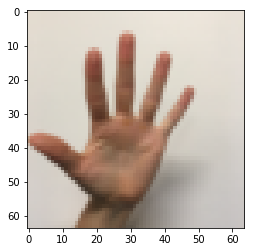

In [58]:
index = 3
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))
print(Y_train[:,3])

 then normalize it by dividing by 255. On top of that, you will convert each label to a one-hot vector as shown in Figure 1. Run the cell below to do so.

In [59]:
 #Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


# Run the following cell to train your model!

Cost after epoch 0: 2.820227
Cost after epoch 100: 1.534812
Cost after epoch 200: 1.241858
Cost after epoch 300: 1.060837
Cost after epoch 400: 0.970207
Cost after epoch 500: 0.892169
Cost after epoch 600: 0.822445
Cost after epoch 700: 0.797863
Cost after epoch 800: 0.743814
Cost after epoch 900: 0.711390
Cost after epoch 1000: 0.678993
Cost after epoch 1100: 0.639956
Cost after epoch 1200: 0.625842
Cost after epoch 1300: 0.596805
Cost after epoch 1400: 0.606274
Cost after epoch 1500: 0.586324
Cost after epoch 1600: 0.572353
Cost after epoch 1700: 0.563088
Cost after epoch 1800: 0.569091
Cost after epoch 1900: 0.545874
Cost after epoch 2000: 0.538217
Cost after epoch 2100: 0.548277
Cost after epoch 2200: 0.540713
Cost after epoch 2300: 0.533856
Cost after epoch 2400: 0.528162


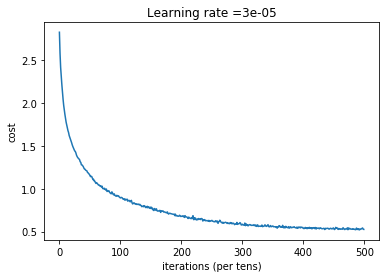

Parameters have been trained!
Train Accuracy: 0.999074
Test Accuracy: 0.891667


In [60]:
parameters = model(X_train, Y_train, X_test, Y_test)

# Testing with my own image

Your algorithm predicts: y = 2
Tensor("Add_14:0", shape=(6, 1), dtype=float32)


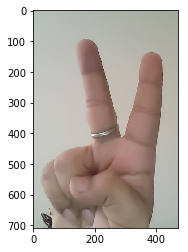

In [64]:
my_image = "new_two_edited.jpg"

# We preprocess your image to fit your algorithm.
fname = "datasets/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T
my_image_prediction, flag = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))
print(flag)
x = tf.Print(flag,[flag])
#print(x.eval())

# Things to remember
- Tensorflow is a programming framework used in deep learning
- The two main object classes in tensorflow are Tensors and Operators. 
- When you code in tensorflow you have to take the following steps:
    - Create a graph containing Tensors (Variables, Placeholders ...) and Operations (tf.matmul, tf.add, ...)
    - Create a session
    - Initialize the session
    - Run the session to execute the graph
- You can execute the graph multiple times as you've seen in model()
- The backpropagation and optimization is automatically done when running the session on the "optimizer" object.